Import package

In [1]:
import numpy as np
import scipy
#from scipy.io import wavfile
import os
#import soundfile as sf
from matplotlib import pyplot as plt
import librosa
import librosa.display
print (librosa.__version__)
from tqdm import tqdm
import pandas as pd

0.10.1


File Path Parameter

In [36]:
Audio_root_folder = 'data/data/train'
Audio_root_test = 'data/data/test'
invalid_folder = '.DS_Store'
invalid_folder2 = 'list_test.txt'

In [37]:
# list all sub folder 
folders = os.listdir(Audio_root_folder)
folders = [item for item in folders if item != invalid_folder]
test_folders = os.listdir(Audio_root_test)
test_folders = [item for item in test_folders if item != invalid_folder2]

Set random seed <br>
These seeds will be used to extract validation from training

In [4]:

random_numbers_all = []
used_numbers = np.array([])
for j in tqdm(range(9)):
    random_numbers_1fold = []
    for i in range(10):
        start = i * 90
        end = (i + 1) * 90
        
        # Randomly select 10 numbers from the subrange
        number_pool = [item for item in range(start, end) if item not in used_numbers]
        numbers = np.random.choice(number_pool, 10, replace=False)
        random_numbers_1fold.extend(numbers)
        used_numbers = np.append(used_numbers,random_numbers_1fold)

    random_numbers_1fold = np.array(random_numbers_1fold)
    random_numbers_1fold = np.sort(random_numbers_1fold)
    random_numbers_all.append(random_numbers_1fold)
random_numbers_all = np.array(random_numbers_all)
#random_numbers_all

100%|██████████| 9/9 [00:00<00:00, 202.21it/s]


Set number of mfccs

In [5]:
mfcc_no_all = [13, 26, 50, 100]

Training <br>
<font color = 'red'>Need to specify saved path in the bottom

In [ ]:
########## MFCC ############

y_len = 1290 # if hop_length = 512
# y_len = 2580 # if hop_length = 256
for mfcc_no in mfcc_no_all[2:3]: # mfcc = 50
    for k_fold in range(9):
        Labels = []
        Features = []
        for i in tqdm(folders):
            Audios = os.listdir(Audio_root_folder + '/' + i)
            Audios = [item for item in Audios if item != invalid_folder]
            for j in tqdm(Audios):                
                data, sampling_rate = librosa.load(Audio_root_folder + '/' + i + '/' + j, sr=None)

                S = librosa.feature.melspectrogram(y=data, sr=sampling_rate,n_fft = 2048, hop_length = 512)
                mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), sr=sampling_rate, n_mfcc=mfcc_no)
                mfccs = mfccs[:,0:y_len]
                mfcc_delta = librosa.feature.delta(mfccs)
                mfcc_delta = mfcc_delta[:,0:y_len]
                mfcc_delta_delta = librosa.feature.delta(mfccs, order = 2)
                mfcc_delta_delta = mfcc_delta_delta[:,0:y_len]
                OneSong_Fea = np.array([mfccs,mfcc_delta, mfcc_delta_delta])
                Labels.append(folders.index(i))
                Features.append(OneSong_Fea)

        Features = np.array(Features)
        Labels = np.array(Labels)
        # Split the matrix into training and validation sets
        val_mask = np.zeros(Features.shape[0], dtype=bool)
        val_mask[random_numbers_all[k_fold]] = True
        val_Fea_set = Features[val_mask]
        val_Lab_set = Labels[val_mask]
        train_Fea_set = Features[~val_mask]
        train_Lab_set = Labels[~val_mask]
        print(f"Training: {train_Fea_set.shape}")
        print(f"Validation: {val_Fea_set.shape}")
        ################# save to your own path ##############
        np.save('data/npy/CNN/Fea_train_mfcc_fold' + str(k_fold) + '_' + str(mfcc_no) + '.npy', train_Fea_set)
        np.save('data/npy/CNN/Lab_train_mfcc_fold' + str(k_fold) + '_' + str(mfcc_no) + '.npy', train_Lab_set)
        np.save('data/npy/CNN/Fea_val_mfcc_fold' + str(k_fold) + '_' + str(mfcc_no) + '.npy', val_Fea_set)
        np.save('data/npy/CNN/Lab_val_mfcc_fold' + str(k_fold) + '_' + str(mfcc_no) + '.npy', val_Lab_set)
        ################# save to your own path ##############

Testing <br>
<font color = 'red'>Need to specify saved path in the bottom

In [72]:
########## MFCC ############
for mfcc_no in mfcc_no_all:
    Features = []
    test_df = pd.read_csv('data/data/test/list_test.txt',header = None)
    for i in tqdm(test_df.index):

        data, sampling_rate = librosa.load(Audio_root_test + '/' + test_df.loc[i,0], sr=None)
        S = librosa.feature.melspectrogram(y=data, sr=sampling_rate,n_fft = 2048, hop_length = 512)
        mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), sr=sampling_rate, n_mfcc=mfcc_no)
        mfccs = mfccs[:,0:y_len]
        mfcc_delta = librosa.feature.delta(mfccs)
        mfcc_delta = mfcc_delta[:,0:y_len]
        mfcc_delta_delta = librosa.feature.delta(mfccs, order = 2)
        mfcc_delta_delta = mfcc_delta_delta[:,0:y_len]
        OneSong_Fea = np.array([mfccs,mfcc_delta, mfcc_delta_delta])
        Features.append(OneSong_Fea)

    Features = np.array(Features)
    ################# save to your own path ##############
    np.save('data/npy/CNN/test_mfcc' + str(mfcc_no) + '.npy', Features)
    ################# save to your own path ##############
    Features.shape

100%|██████████| 100/100 [00:01<00:00, 57.10it/s]


Show the mfcc plots

(661504,)
(661503,)
(661502,)


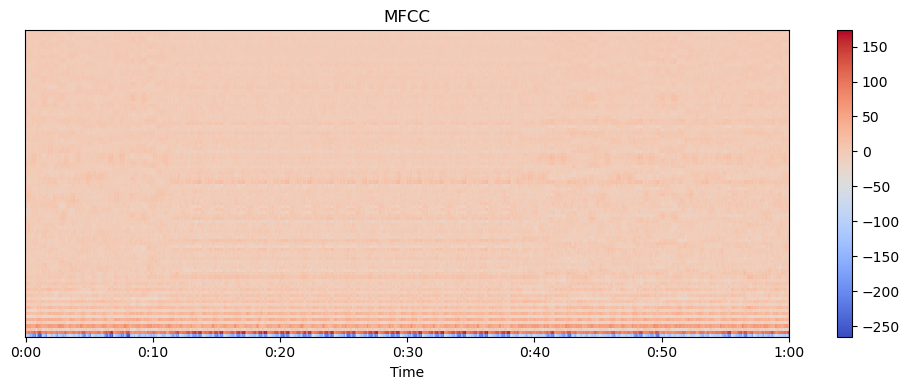

(100, 2585)


In [ ]:
delta_data = np.diff(data)
delta_delta_data = np.diff(delta_data)
mfcc_delta = librosa.feature.delta(mfccs)
print (data.shape)
print (delta_data.shape)
print (delta_delta_data.shape)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time', sr=sampling_rate)
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()
print (mfccs.shape)
#plt.plot(mfccs, alpha = 0.5)

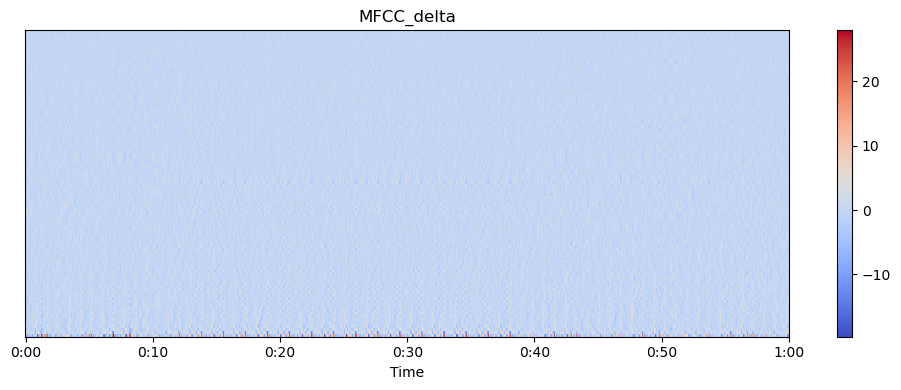

(100, 2585)


In [ ]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc_delta, x_axis='time', sr=sampling_rate)
plt.colorbar()
plt.title('MFCC_delta')
plt.tight_layout()
plt.show()
print (mfcc_delta.shape)

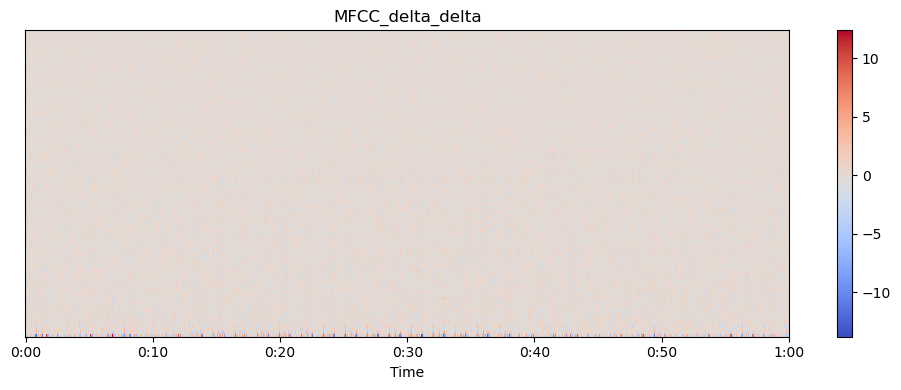

(100, 2585)


In [ ]:
mfcc_delta_delta = librosa.feature.delta(mfccs, order = 2)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc_delta_delta, x_axis='time', sr=sampling_rate)
plt.colorbar()
plt.title('MFCC_delta_delta')
plt.tight_layout()
plt.show()
print (mfcc_delta_delta.shape)

Extract FFT <br>
<font color = 'red'>Need to specify saved path in line 25

100%|██████████| 10/10 [00:05<00:00,  1.87it/s]
c:\Users\dawnmoon\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


array([[0.13146342, 0.5207568 , 0.16403734, ..., 0.        , 0.        ,
        0.        ],
       [0.12324979, 0.06872778, 0.14586364, ..., 0.        , 0.        ,
        0.        ],
       [0.13313951, 0.07828412, 0.23898245, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.21902524, 0.05085127, 0.0957718 , ..., 0.        , 0.        ,
        1.        ],
       [0.05678898, 0.10717875, 0.0416497 , ..., 0.        , 0.        ,
        1.        ],
       [0.00978074, 0.01614857, 0.00450092, ..., 0.        , 0.        ,
        1.        ]])

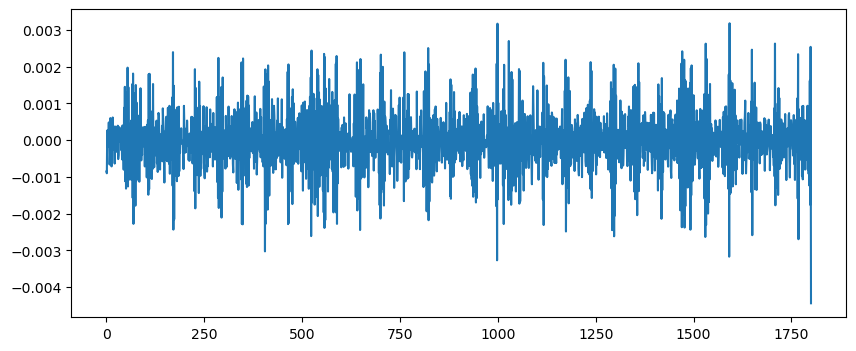

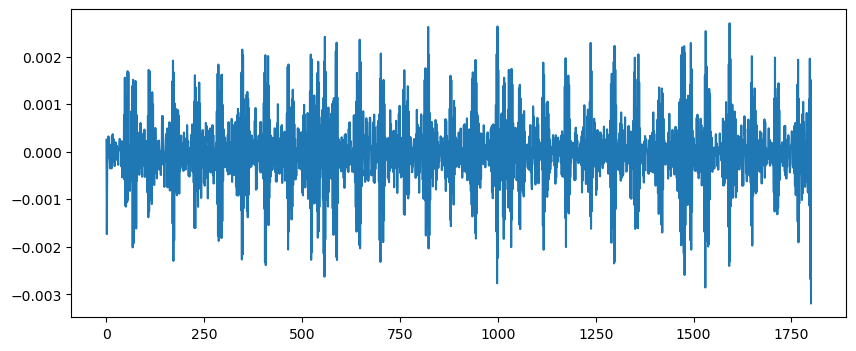

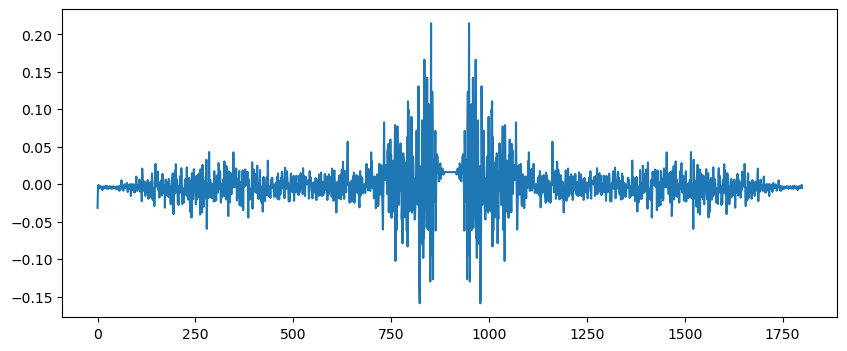

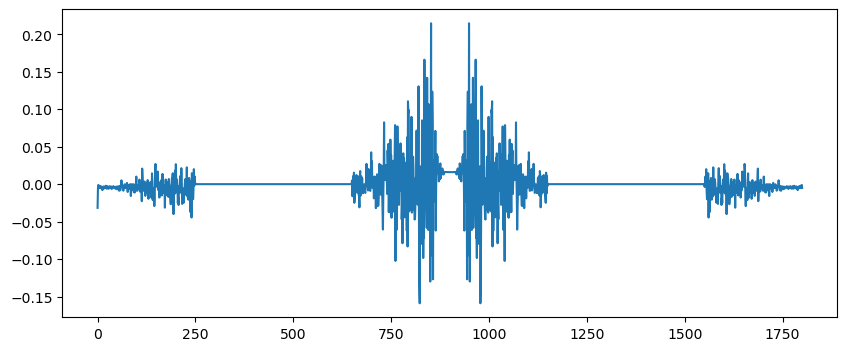

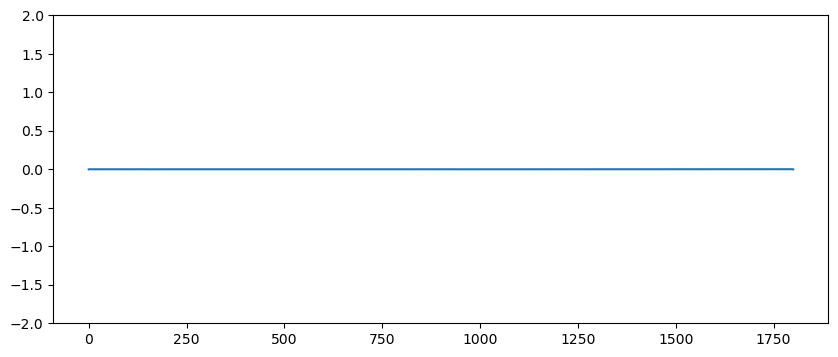

In [131]:
Features_Labels = []
for i in tqdm(folders):
    Audios = os.listdir(Audio_root_folder + '/' + i)[1:]
    label = np.zeros([1,10]).flatten()
    #print (i)
    label[folders.index(i)] = 1
    
    #label
    for j in tqdm(Audios):
        #print (j)
        #print (Audio_root_folder+'/'+i+)
        #print (Audios)
        
        data, sampling_rate = librosa.load(Audio_root_folder + '/' + i + '/' + j, sr=60)
        data_fft = np.fft.fft(data)
        # Low Freq
        fft_low = np.abs(data_fft[int(data_fft.shape[0]/2) - 250 : int(data_fft.shape[0] /2) + 250])
        # High Freq
        fft_high = np.abs([data_fft[:250],data_fft[-250:]])
        Feature_fft = np.append(fft_low, fft_high)
        Features_Labels.append(np.append(Feature_fft,label))

Features_Labels = np.array(Features_Labels)

################# save to your own path ##############
np.save('data/npy/train_fft_LH_500.npy', Features_Labels)
################# save to your own path ##############

fig, ax = plt.subplots(figsize = (10,4))
ax.plot(data)

data_fft_copy = data_fft.copy()
# Low Freq
data_fft_copy[:int(data_fft.shape[0]/2) - 250] = 0
data_fft_copy[int(data_fft.shape[0] /2) + 250:] = 0
# High Freq
data_fft_copy[:250] = data_fft[:250]
data_fft_copy[data_fft_copy.shape[0]-250:] = data_fft[data_fft.shape[0]-250:]

fig0, ax0 = plt.subplots(figsize = (10,4))
ax0.plot(np.fft.ifft(data_fft_copy))
#ax0.set_ylim(-2,2)

fig1, ax1 = plt.subplots(figsize = (10,4))
ax1.plot(data_fft)

fig3, ax3 = plt.subplots(figsize = (10,4))
ax3.plot(data_fft_copy)

fig2, ax2 = plt.subplots(figsize = (10,4))
ax2.plot(data - np.fft.ifft(data_fft_copy))
ax2.set_ylim(-2,2)
Features_Labels